In [1]:
#Load packages 
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 
import random
import torch.nn.functional as F

## Read data

In [2]:
#Load data
train_data = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')

In [3]:
#Drop all images with missing keypoints
train_data = train_data.dropna() 

#New size of training data
train_data.shape

(2140, 31)

### Plot data

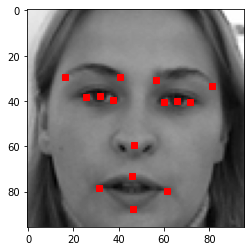

In [4]:
#Helper functions found from: https://www.kaggle.com/code/james146/facial-keypoints-detection-pytorch 
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
def plot_sample(image, keypoint,title):
    image = image.reshape(96,96)
    fig, axis = plt.subplots()
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)
    
show_image_with_keypoints_by_id(train_data, 168)

## Augmentation
1. Horizontal Flip
2. Blur
3. Invert

In [5]:
#Load data to get images and keypoints in a form we can augment
def data_for_aug(file_name):
    labels=[file_name.iloc[i].values[0:30] for i in range(len(file_name))]
    inputs=[file_name.iloc[i].values[30:31] for i in range(len(file_name))]
    
    inputs = [(i[0].split()) for i in inputs]
    inputs = [[int(i) for i in j] for j in inputs] 
    inputs = [np.reshape(i, (96,96)) for i in inputs]
    inputs = [np.expand_dims(i,0) for i in inputs]
    inputs = torch.tensor(inputs, dtype=torch.float)
    
    return labels, inputs

In [6]:
keypoints_train_data , images_train_data = data_for_aug(train_data)

<ipython-input-5-cd9c4f294a9d>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  inputs = torch.tensor(inputs, dtype=torch.float)


In [7]:
#Helper function to delete unchanged images
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

### Horizontal Flip

In [8]:
#Function for flip with inspiration from: https://www.kaggle.com/code/balraj98/data-augmentation-for-facial-keypoint-detection
random.seed(40)

def left_right_flip(images, keypoints):
    
    flipper = transforms.RandomHorizontalFlip(p = 0.5)
    flipped_images = [flipper(image) for image in images]
    
    flpd_imgs = [1 if torch.equal(images[i],flipped_images[i]) == False else 0 for i in range(len(images))]
    flipped_keypoints = []
    list_of_indices = []
    k = 0
    for idx, sample_keypoints in enumerate(keypoints):
        if flpd_imgs[k] == 1:
            flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])
        else:
            list_of_indices.append(k)
        k += 1
    
    delete_multiple_element(flipped_images, list_of_indices)
    
    flipped_keypoints = torch.tensor(flipped_keypoints, dtype=torch.float)
    return flipped_images, flipped_keypoints, flpd_imgs


#Function used on data
flipped_train_images, flipped_train_keypoints, index_flip = left_right_flip(images_train_data , keypoints_train_data)

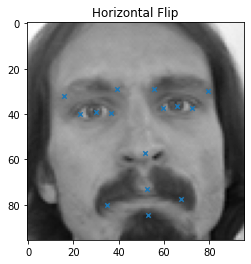

In [22]:
#Flipped image with keypoints 
plot_sample(flipped_train_images[0],flipped_train_keypoints[0], "Horizontal Flip" )

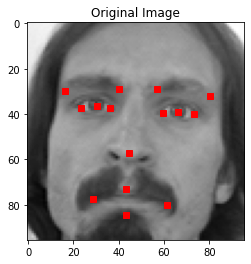

In [23]:
#Original image to verify the flip happened
i=0
while True:
    if index_flip[i] == 1:
        show_image_with_keypoints_by_id(train_data, i)
        plt.title('Original Image')
        break
    i += 1

### Blur

In [11]:
#Function for blur 
def blur(images, keypoints):
    
    random_blur_index = np.random.randint(0,2,len(images))
    blurred_images = []
    for i in range(len(images)):
        if random_blur_index[i] == 1:
            blurred_images.append(images[i] + (200**0.5)*torch.randn(1,96,96))
        else:
            blurred_images.append(images[i])
    
    list_of_indices = []
    blurred_keypoints = []
    k = 0
    for idx, sample_keypoints in enumerate(keypoints):
        if random_blur_index[k] == 1:
            blurred_keypoints.append([coor for idx,coor in enumerate(sample_keypoints)])
        else:
            list_of_indices.append(k)
        k += 1
    
    delete_multiple_element(blurred_images, list_of_indices)
    
    blurred_keypoints = torch.tensor(blurred_keypoints, dtype=torch.float)

    return blurred_images, blurred_keypoints, random_blur_index

#Function used on data
blurred_train_images, blurred_train_keypoints, index_blur = blur(images_train_data , keypoints_train_data)   

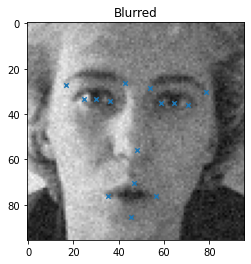

In [12]:
#Blurred image with keypoints 
plot_sample(blurred_train_images[0],blurred_train_keypoints[0], "Blurred" )

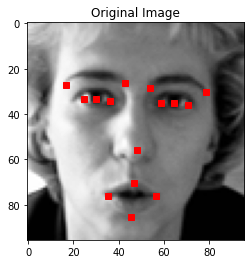

In [24]:
#Original image to verify the flip happened
i=0
while True:
    if index_blur[i] == 1:
        show_image_with_keypoints_by_id(train_data, i)
        plt.title('Original Image')
        break
    i += 1

### Invert

In [14]:
#Function for invert 
def invert(images, keypoints):
    inverter = transforms.RandomInvert()
    inverted_image = [inverter(image) for image in images]
    
    inv_imgs = [1 if torch.equal(images[i],inverted_image[i]) == False else 0 for i in range(len(images))]
    
    inv_keypoints = []
    list_of_indices = []
    k = 0
    for idx, sample_keypoints in enumerate(keypoints):
        if inv_imgs[k] == 1:
            inv_keypoints.append([coor for idx,coor in enumerate(sample_keypoints)])
        else:
            list_of_indices.append(k)
        k += 1
    
    delete_multiple_element(inverted_image, list_of_indices)
    
    inv_keypoints = torch.tensor(inv_keypoints, dtype=torch.float)

    return inverted_image, inv_keypoints, inv_imgs

#Function used on data
inv_train_images, inv_train_keypoints, index_invert = invert(images_train_data , keypoints_train_data)     

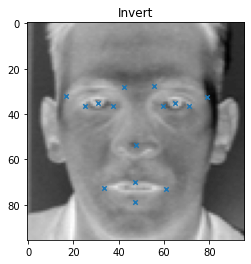

In [15]:
#Inverted image with keypoints 
plot_sample(inv_train_images[0],inv_train_keypoints[0], "Invert" )

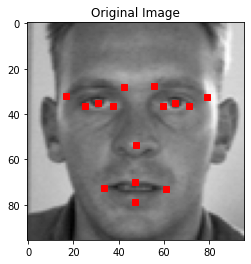

In [25]:
#Original image to verify the invert happened
i=0
while True:
    if index_invert[i] == 1:
        show_image_with_keypoints_by_id(train_data, i)
        plt.title('Original Image')
        break
    i += 1

## Adding augmentated data to dataframe

In [17]:
#Change data structure to fit original data
def tensor_to_string(image):
    image = np.array(image)
    image = image.flatten()
    image = image.astype(int)
    image = list(image)
    image = [str(i) for i in image]
    image = ' '.join(image)
    return image

In [18]:
#Function to add new data to original data 
def add_aug_data(org_data, aug_image, aug_keypoints):
    last_row = len(org_data)
    
    for i in range(len(aug_keypoints)):
        row = []
        for j in range(30):
            row.append(float(aug_keypoints[i][j]))
        row.append(tensor_to_string(aug_image[i]))
        org_data.loc[last_row + i] = row
    
    return org_data
    

In [19]:
#Function used on all 3 augmentation 
train_data_flip = add_aug_data(train_data, flipped_train_images, flipped_train_keypoints)
train_data_flip_blur = add_aug_data(train_data_flip, blurred_train_images, blurred_train_keypoints)
train_data_flip_blur_inv = add_aug_data(train_data_flip_blur, inv_train_images, inv_train_keypoints)

In [20]:
#New lenght of dataset 
len(train_data_flip_blur_inv)

5035

In [21]:
#Save new dataset

#train_data_flip_blur_inv.to_csv('training_with_aug.csv')

